# Retail Sales Forecasting - 1 of 5

This is the first in a series of 5 Jupyter Notebooks on forecasting sales for a small, boutique retailer. Sales forecasting is the first step in a bigger effort to automate inventory forecasting and purchasing. This initial project is focused on forecasting retail sales for the week ahead.

### Notebook Setup

In [1]:
%matplotlib inline

from __future__ import division
from __future__ import print_function

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.graphics.tsaplots import plot_acf

# Homegrown utilities for making lags, back testing, etc.
from lag_transformer import LagTransformer
from back_test import get_first_sunday, calc_metrics

DAYS_IN_WEEK = 7
MIN_TRAIN_SIZE = DAYS_IN_WEEK * 19

plt.style.use('ggplot')

### Load Sales Data

Actual gross sales by day from late 2017.

In [2]:
df = pd.read_excel('../data/daily-sales.xlsx', index_col='date', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2017-11-17 to 2018-11-17
Data columns (total 9 columns):
year          366 non-null int64
month         366 non-null object
week          366 non-null int64
day           366 non-null object
is_open       366 non-null int64
is_holiday    366 non-null int64
sales         366 non-null float64
customers     366 non-null int64
avg_sale      366 non-null float64
dtypes: float64(2), int64(5), object(2)
memory usage: 28.6+ KB


In [3]:
df.head()

,year,month,week,day,is_open,is_holiday,sales,customers,avg_sale
date,,,,,,,,,
2017-11-17,2017,Nov,46,fri,1,0,348.63,11,31.693636
2017-11-18,2017,Nov,46,sat,1,0,1334.38,16,83.398750
2017-11-19,2017,Nov,46,sun,0,0,0.00,0,0.000000
2017-11-20,2017,Nov,47,mon,1,0,512.08,3,170.693333
2017-11-21,2017,Nov,47,tue,1,0,0.00,0,0.000000


In [4]:
df['sales'].describe()

count     366.000000
mean      710.298661
std       628.412676
min         0.000000
25%       240.267500
50%       559.600000
75%      1060.692500
max      3493.050000
Name: sales, dtype: float64

### Baseline - "What did we do last week ?"

If, on Monday morning, you asked the non-technical owners of this business to predict the coming week's daily sales they would simply look to last week. To forecast Monday, they would look at the prior Monday, same for Tuesday, Wednesday, etc. So, this is what we'll use at the baseline forecasting method and see if a suite of machine learning algorithms can perform better than a naive forecast.

In [5]:
y_col = 'sales'
x_cols = ['sales']
lags = [7]

# You can find code for LogTransformer in this Github repo.
trans = LagTransformer(x_cols=x_cols, y_col=y_col, lags=lags)
df_lag = trans.fit_transform(df)

# Trim off the first few rows so we start on a Sunday
start_idx = get_first_sunday(df_lag)
if start_idx > 0:
    df_lag.drop(df_lag.index[:start_idx], inplace=True)
    
# Make the column order and name match the models
df_lag.columns = ['yhat', 'y']
df = df_lag[['y', 'yhat']]

df.tail(16)

,y,yhat
date,,
2018-11-02,1097.56,1541.65
2018-11-03,1780.13,1089.23
2018-11-04,0.00,0.00
2018-11-05,669.57,832.45
2018-11-06,431.19,359.20
2018-11-07,531.03,1252.43
2018-11-08,388.11,656.54
2018-11-09,849.25,1097.56
2018-11-10,2007.19,1780.13


### Baseline Cross Validation

In [6]:
# Calculate error metrics in the same way as the machine learning
# models in notebooks 2 - 5 to see how the baseline method stacks up.

# Start at the same date as the other models
df_m = calc_metrics(df, start=MIN_TRAIN_SIZE)
weeks = len(df_m.index)

print('MAPE for {} steps = {:.2f}%'.format(len(df_m), df_m.MAPE.mean()))
print('RMSE for {} steps = {:.2f}'.format(len(df_m), df_m.RMSE.mean()))
df_m.head(12)

MAPE for 32 steps = 25.37%
RMSE for 32 steps = 596.27


,MAPE,RMSE
date,,
2018-04-08,47.513829,559.964104
2018-04-15,46.465804,627.683017
2018-04-22,21.796413,905.107335
2018-04-29,21.685776,609.689118
2018-05-06,35.934362,750.079095
2018-05-13,53.888291,661.963477
2018-05-20,44.445957,919.577002
2018-05-27,50.511831,965.142793
2018-06-03,20.145059,538.944642


### Visualize Predicted vs Actual Sales

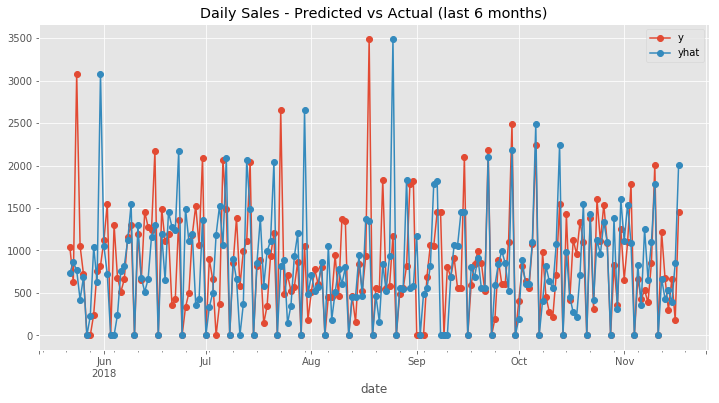

In [7]:
df[-180:].plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual (last 6 months)')
plt.show()

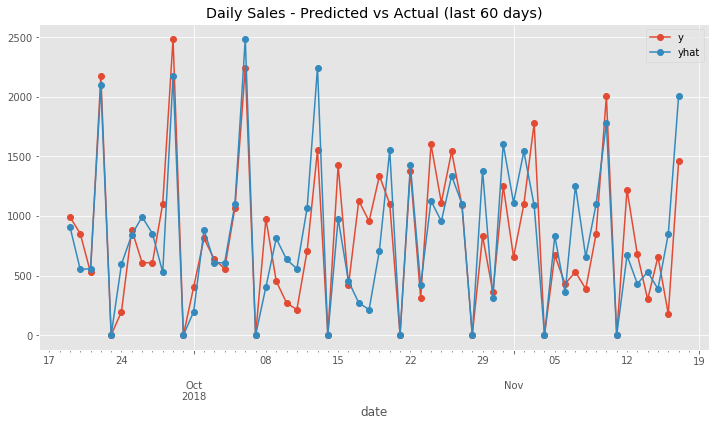

In [8]:
df[-60:].plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual (last 60 days)')
plt.show()